In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# If turned on, we'll run some models that take more than 20s seconds to run on a good machine
RUN_HEAVY_MODELS = True

In [3]:
df_master = pd.read_csv("..\\Data_Sets\\processed\\completeData_1995-2022.csv")

In [4]:
# Converting boolean columns to integer
df_master = df_master.astype({col: 'int' for col in df_master.select_dtypes(['bool']).columns})

# Renaming Economic freedom columns
df_master = df_master.rename(columns={
    'Property Rights':'EF_Property Rights',
    'Government Integrity':'EF_Government Integrity',
    'Judicial Effectiveness':'EF_Judicial Effectiveness',
    'Government Spending':'EF_Government Spending',
    'Tax Burden':'EF_Tax Burden',
    'Fiscal Health':'EF_Fiscal Health',
    'Business Freedom':'EF_Business Freedom',
    'Monetary Freedom':'EF_Monetary Freedom',
    'Labor Freedom':'EF_Labor Freedom',
    'Financial Freedom':'EF_Financial Freedom',
    'Investment Freedom':'EF_Investment Freedom',
    'Trade Freedom':'EF_Trade Freedom'
})

# predictors dataFrame
df_predictors = df_master.iloc[:,2:]
df_predictors = df_predictors.drop(['GDP per capita (current USD)', 'Country Quintile'], axis=1)

# Dealing with Multicollinearity

In [5]:
# Computing correlation matrix
correlation_matrix = df_predictors.corr()

# Identifying pairs of features with high correlation coefficients (greater than 0.7 in absolute value)
highly_correlated_pairs = {}
for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if idx == col:
            continue
        if abs(correlation_matrix.loc[idx, col]) > 0.7:
            pair = tuple(sorted([idx, col]))
            if pair not in highly_correlated_pairs:
                highly_correlated_pairs[pair] = correlation_matrix.loc[idx, col]

# Convert the dictionary to a DataFrame for better display
df_highlyCorrelated = pd.DataFrame(list(highly_correlated_pairs.items()), columns=["Feature Pair", "Correlation Coefficient"])

df_highlyCorrelated

,Feature Pair,Correlation Coefficient
0,"(EF_Government Integrity, EF_Property Rights)",0.848972
1,"(EF_Judicial Effectiveness, EF_Property Rights)",0.713712
2,"(EF_Business Freedom, EF_Property Rights)",0.728501
3,"(EF_Financial Freedom, EF_Investment Freedom)",0.747306
4,"(Human Development Index, Under-5 mortality ra...",-0.864344
5,"(isLandLocked, n_accessToSea)",-0.902937
6,"(Amount of Ports, Expanded EconZone Area)",0.710652
7,"(Amount of Ports, H index (Academic Papers))",0.794973
8,"(Amount of Ports, Migration Volume)",0.764736
9,"(Average Temperature (C), Distance from Equator)",-0.857508


Based on the results above, we'll delete Average Temperature (C), isLandLocked, HDI as they all have more than 0.85 absolute correlation.

There are other high-correlation pairs [like (Amount of Ports, H index (Academic Papers))]. We'll keep them (and others like it) as they are from unrelated subjects.
To avoid multi-collinearity in Economic Freedom, we'll group their features into their respective categories:

- Rule of Law
- Open Markets
- Government Size
- Regulatory Efficiency

In [6]:
# PS: I've removed both 'Human Development Index' and 'Under-5 mortality rate (per 1k live births)' as they're most likely directly caused by GDP, which distorts our model.
# Feature Selection: A formal verification on all features is necessary (using tests like granger causality tests), after data has been properly transformed to deal with TimeSeries Stationarity.
# This is currently too advanced for me to do properly. So, for now, I'll just use plain common sense.

df_master = df_master.drop(['Average Temperature (C)', 'isLandLocked', 'Human Development Index', 'Under-5 mortality rate (per 1k live births)'], axis=1)


# Normalizing Data

In [7]:
# Selecting only numeric columns (that are not one-hot encoded)
colSelect = list(df_master.columns[2:]) # Excluding Country Name and Index Year
colSelect.remove('Country Quintile')
colSelect.remove('GDP per capita (current USD)')

# Fit and transform the selected numeric columns
df_master[colSelect] = MinMaxScaler().fit_transform(df_master[colSelect])

# Splitting the Data

In [8]:
def dataSplitter(df, quintile = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], splitFactor = 0.8):

    YEAR = int(((2022)-1995)*splitFactor) + 1995

    # Filtering data by quintile
    data_dummies = df.copy().loc[df['Country Quintile'].isin(quintile), :].drop(columns=['Country Quintile', 'Country Name'])

    # Filtering data by target and predictors 
    X = data_dummies.drop(columns=["GDP per capita (current USD)"])
    y = data_dummies[['Index Year',"GDP per capita (current USD)"]]

    # Filtering data by time
    X_train = X.loc[X['Index Year'] <= YEAR].drop(columns=['Index Year'])
    X_test = X.loc[X['Index Year'] > YEAR].drop(columns=['Index Year'])

    y_train = y.loc[y['Index Year'] <= YEAR].drop(columns=['Index Year']).squeeze()
    y_test = y.loc[y['Index Year'] > YEAR].drop(columns=['Index Year']).squeeze()

    return X_train, X_test, y_train, y_test

# Thoughts

KNN is by far the best model out of these 4 approaches. Yet, it inherently is a "piecewise constant" model, which means it's not good to output precise results given minor changes to the predictor variables.

Second best model is a Gradient Boosting technique. So we'll use that.

**4 steps remain, for further analysis:**
- *Cross-Validation:* We've been rather stiff with our data separation. Let's run a Rolling Window CV to get a better sense of how this model would operate on realworld data from now on.
- *Feature Importance:* Let's define how important Economic Freedom is for our model to predict GDP per Capita.
- *Plot results:* Actual Values vs Predicted Values (for a fixed time period)
- *Simulate Country GDP per Capita:* Given some parameters, let's run some numbers for some countries.

### Rolling Window Cross-Validation
**sklearn.model_selection's TimeSeriesSplit:**

We'll start at the earliest 15 years as training data, and n+1 (in this case, the 16th year) as test data. We'll roll one year at a time for each iteration.

In [ ]:
# Define your Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, random_state=42)

sorted_df = df_master.sort_values(by='Index Year')

n_splits = len(sorted_df['Index Year'].unique()) - 15  # number of years - 15
tscv = TimeSeriesSplit(n_splits=n_splits)

# Variables to store performance metrics
mse_scores = []

# Loop for each train-test split
for train_index, test_index in tscv.split(sorted_df):
    # Splitting the data
    X_train = sorted_df.iloc[train_index, :].drop(columns=['Country Quintile', 'Country Name', 'Index Year'])
    X_test = sorted_df.iloc[test_index, :].drop(columns=['Country Quintile', 'Country Name', 'Index Year'])
    y_train, y_test = X_train['GDP per capita (current USD)'], X_test['GDP per capita (current USD)']

    # Fit model
    gb_model.fit(X_train.drop(['GDP per capita (current USD)'], axis=1), y_train)

    # Predict and calculate MSE
    predictions = gb_model.predict(X_test.drop(['GDP per capita (current USD)'], axis=1))
    mse = mean_absolute_error(y_test, predictions)
    mse_scores.append(mse)

# Print or plot the MSE scores for each split
print("MSE scores for each year:", mse_scores)

It seems our model is working fine throughout the years.

### Feature Importance


In [ ]:
# Defining the target and predictors
X = df_master.drop(columns=['Country Quintile', 'Country Name', 'Index Year', 'GDP per capita (current USD)'])
y = df_master['GDP per capita (current USD)']

gb_model = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, random_state=42)
gb_model.fit(X, y)
yHat = gb_model.predict(X)

# Extract feature importances
importances = gb_model.feature_importances_
feature_names = X.columns

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


In [ ]:
dict_featureGroupings = {
    'geoPolitical':
        ['Total population','n_accessToSea','Area Size (km2)', 'Expanded EconZone Area',
        'Distance from Equator', 'Natural Resources','ClimateType_AF', 'Arable Land pct',
       'ClimateType_AM', 'ClimateType_AW', 'ClimateType_BS', 'ClimateType_BW',
       'ClimateType_CF', 'ClimateType_CW', 'ClimateType_DF','Migration Volume',
       'Amount of Country Neighbours','Population Density','Shared Borders (in pct)'],

    'Economic Freedom':
        ['EF_Property Rights', 'EF_Government Integrity',
       'EF_Judicial Effectiveness', 'EF_Government Spending', 'EF_Tax Burden',
       'EF_Fiscal Health', 'EF_Business Freedom', 'EF_Monetary Freedom',
       'EF_Labor Freedom', 'EF_Financial Freedom', 'EF_Investment Freedom',
       'EF_Trade Freedom'],

    'Infra & Other Economic Factors':
        ['Gini', 'Inflation CPI','Amount of Ports',
       'Real interest rate', 'Labor force size', f'Trade (% of GDP)',
       f'Trade in services (% of GDP)','Rail Density','Pctg of Rail Electrified',
       'Death rates from disasters', 'Human Development Index'],

    'Education & Research':
        ['H index (Academic Papers)','Qualified Labor Force pct','Harmonized Test Scores'],

    'Religion':
        ['Religion_buddhism','Religion_christianity', 'Religion_folk',
         'Religion_hinduism','Religion_islam', 'Religion_no religion'],
    
    'Conflicts & Wars':
    ['Amount of Major Conflicts_Since 1900','Proportion of Rival Neighbours'],

    'Neighbour Quality':
    ['Local Mean GDP per Capita','Local Mean GDP','Local Mean Gini']
}

# Inverting the dict to create a mapping from feature to group
feature_to_group = {feature: group for group, features in dict_featureGroupings.items() for feature in features}

# Adding the 'Feature Group' column to the top_features DataFrame
feature_importance_df['Feature Group'] = feature_importance_df['Feature'].apply(lambda x: feature_to_group.get(x, 'Unknown'))


In [ ]:
def plotSunBurst(df, title):
    # Grouping the data by 'Feature Group' and 'Feature' and summing up the 'Importance'
    grouped_data = df.groupby(['Feature Group', 'Feature']).agg({'Importance': 'sum'}).reset_index()

    # Calculate the total importance
    total_importance = grouped_data['Importance'].sum()

    # Filter out rows with zero or near-zero importance
    filtered_data = grouped_data #[grouped_data['Importance'] > 1e-10].copy()

    # Calculate the relative importance as a proportion of the total
    filtered_data.loc[:, 'Relative Importance'] = filtered_data['Importance'] / total_importance

    # Create the sunburst plot with relative importance
    fig = px.sunburst(
        filtered_data,
        path=['Feature Group', 'Feature'],  # Define the hierarchy
        values='Relative Importance',       # Define the size of the sunburst sectors as a proportion of the total
    )

    # Update the layout with the specified title and adjusted width and height
    fig.update_layout(
        title={
            'text': title,
            'y': 0.97,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        width=1270,   # Adjust the width as needed
        height=920    # Adjust the height as needed
    )

    # Show the plot
    fig.show()


plotSunBurst(
    feature_importance_df,
    f"Feature Importance (excluding features under 1e-10 importance)<br><sub>on Gradient Boosting Regressor for predicting GDP per Capita</sub>")

In [ ]:
# Define the list of feature groups to be dropped
groups_to_drop = ['geoPolitical', 'Religion', 'Neighbour Quality']
top_features_filtered = feature_importance_df[~feature_importance_df['Feature Group'].isin(groups_to_drop)]

plotSunBurst(
    top_features_filtered,
    f"Feature Importance (excluding factors beyond our control)<br><sub>on Gradient Boosting Regressor for predicting GDP per Capita</sub>")

### Plotting model performance

In [ ]:
X_train, X_test, y_train, y_test = dataSplitter(df_master)


model = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

yHat = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, yHat, alpha=0.5)  # alpha for transparency
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual GDP per Capita (USD)')
plt.ylabel('Predicted GDP per Capita (USD)')
plt.title('Actual vs Predicted GDP per Capita Values')
plt.show()

In [ ]:
residuals = y_test - yHat

plt.figure(figsize=(10, 6))
sns.residplot(x=yHat, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2})
plt.xlabel('Predicted GDP per Capita (USD)')
plt.ylabel('Residuals')
plt.title('Residual Plot (predicted vs actual values)')
plt.axhline(y=0, color='grey', linestyle='--')

plt.yticks(np.arange(-40000, 40000, 5000))

plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color="blue", kde=True, stat="density", linewidth=0, label='Actual GDP per Capita (USD)')
sns.histplot(yHat, color="green", kde=True, stat="density", linewidth=0, label='Predicted GDP per Capita (USD)')
plt.xlabel('GDP per Capita (USD)')
plt.title('Actual vs Predicted GDP per Capita - Distribution')
plt.legend()
plt.show()

### Simulating hypothetical numbers
Let's swap numbers on 'Economic Freedom', 'Education' and 'Infra and other economic factors' groups: from the original data to different percentile thresholds.

Meaning: What if a certain country were at the top 10%, 50%, 90% of certain indicators, what would their GDP per Capita be predicted at?

##### ***Specific features we'll experiment on***
- All Economic Freedom parameters
- Education: ['H index (Academic Papers)', 'Qualified Labor Force pct', 'Harmonized Test Scores']
- Infra and other economic factors: ['Amount of Ports', 'Real interest rate', 'Labor force size', 
                                    f'Trade (% of GDP)', f'Trade in services (% of GDP)', 'Rail Density',
                                    'Pctg of Rail Electrified']

Obs: Some features are reversed (meaning we're trying to minimize them: the closer to zero, the better). These features are:

- ['Gini', 'Inflation CPI','Death rates from disasters']

#### Plot Function

In [24]:
def calculate_errorEstimate(df):
    '''
        Calculates a poor-man's confidence interval to our model, using residuals.
    '''
    X_train, X_test, y_train, y_test = dataSplitter(df, splitFactor=0.8)

    # Train the model once using the entire training data
    model = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train)

    # Define segments
    start = 500  # Starting value for the segments
    last_value = 90000  # Maximum value before the final segment

    segments = []
    current = start
    while current < last_value:
        next_value = int(max(min(current * 1.25, last_value), current + 1000))
        segments.append((current, next_value))
        current = next_value
    segments.append((last_value, np.inf))  # Add the final segment

    # Dictionary to hold error estimates for each segment
    segment_errors = {}

    for lower_bound, upper_bound in segments:
        # Filter test data for this segment
        segment_indices = (y_test >= lower_bound) & (y_test < upper_bound)
        segment_test = X_test[segment_indices]

        # Check if the segment has any data points
        if len(segment_test) > 0:
            # Predict values for this segment
            segment_predictions = model.predict(segment_test)
            segment_true = y_test[segment_indices]
            segment_residuals = segment_true - segment_predictions

            # Calculate and store error estimate for this segment
            segment_errors[(lower_bound, upper_bound)] = np.std(segment_residuals)
        else:
            # Handle the case where the segment has no data
            segment_errors[(lower_bound, upper_bound)] = None

    return segment_errors

segment_errors = calculate_errorEstimate(df_master)


In [25]:
X_train, _, y_train, _ = dataSplitter(df_master,splitFactor=0.99)
gb_model = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=250, random_state=42)

In [26]:
pd.set_option('display.max_columns', None)

def plot_GDP_projection(countryName = 'Brazil', isFloored = False, onlyEF = False, df = df_master, percentileList = np.arange(0,100,2.5), segment_errors = segment_errors, model = None):
    '''
        Projects GDP per Capita values for any given country in the dataSet,
        testing different values for 'Economic Freedom', 'Education' and 'Infra and other economic factors' features.

        countryName: Name of the country (182 possibilities. Look at df_master['Country Name'].unique() for possibilities)
        isFloored: if True, sets the minimum value for any given feature as the current value
                (in other words, GDP per Capita predictions will never be less than the current GDP per Capita,
                as we can only improve metrics.)
        onlyEF: runs the predicition changing only Economic Freedom features (and leaving the rest as is)
        df: data source
        percentileList: specific percentiles to test on
        segment_errors: calculated previously. Helps us estimate some sort of simpler confidence interval (or expected Error)
        mode: If you have a pretrained model, use that instead

    '''
    predicted_values = {}
    error_bars = {}
    yMax = 1000 # default base value for chart Height
    base_y_test = None

    # Where we store the base parameters to swap later
    Country_parameters = df[(df['Country Name'] == countryName) & (df['Index Year'] == 2022)]

    # Fit GradientBoostingRegressor model
    if not model:
        X_train, _, y_train, _ = dataSplitter(df,splitFactor=0.99)
        model = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, random_state=42)
        model.fit(X_train, y_train)
    
    for percentile in percentileList: 

        # Economic Freedom Columns
        columns_to_update_positively = ['EF_Property Rights', 'EF_Government Integrity',
        'EF_Judicial Effectiveness', 'EF_Fiscal Health', 'EF_Business Freedom',
        'EF_Monetary Freedom','EF_Financial Freedom', 'EF_Investment Freedom',
        'EF_Trade Freedom', 'EF_Tax Burden','EF_Labor Freedom', 'EF_Government Spending']
        
        columns_to_update_negatively = []

        if not onlyEF:
            # Education columns
            columns_to_update_positively.extend(['H index (Academic Papers)', 'Qualified Labor Force pct', 'Harmonized Test Scores'])

            # Infra and other economic factors columns
            columns_to_update_positively.extend(['Amount of Ports', 'Real interest rate', 'Labor force size', 
                                    f'Trade (% of GDP)', f'Trade in services (% of GDP)', 'Rail Density',
                                    'Pctg of Rail Electrified'])
            
            columns_to_update_negatively.extend(['Gini', 'Inflation CPI','Death rates from disasters'])

        
        # For positively affecting columns, update if the current value is less than the percentile value
        for col in columns_to_update_positively:
            if np.issubdtype(df[col].dtype, np.number):
                percentile_value = np.percentile(df[col], percentile)
                if isFloored and Country_parameters.loc[Country_parameters.index[0], col] < percentile_value:
                    Country_parameters.loc[Country_parameters.index[0], col] = percentile_value
                else:
                    Country_parameters.loc[Country_parameters.index[0], col] = percentile_value

        # For negatively affecting columns, update if the current value is greater than the percentile value
        for col in columns_to_update_negatively:
            if np.issubdtype(df[col].dtype, np.number):
                percentile_value = np.percentile(df[col], 100 - percentile)
                if isFloored and Country_parameters.loc[Country_parameters.index[0], col] > percentile_value:
                    Country_parameters.loc[Country_parameters.index[0], col] = percentile_value
                else:
                    Country_parameters.loc[Country_parameters.index[0], col] = percentile_value
        


        X_test = Country_parameters.drop(columns=["GDP per capita (current USD)", 'Country Quintile', 'Country Name', 'Index Year'])
        y_test = Country_parameters[["GDP per capita (current USD)"]]


        # Predict the target variable
        yHat = model.predict(X_test)
        predicted_gdp = yHat[0]

        # Storing min and max values
        if predicted_gdp > yMax:
            yMax = predicted_gdp

        # Store the predicted value for the current percentile
        predicted_values[percentile] = predicted_gdp

        # Determine the error bounds for the predicted GDP
        for (lower_bound, upper_bound), error in segment_errors.items():
            if lower_bound <= predicted_gdp < upper_bound:
                error_lower = predicted_gdp - error
                error_upper = predicted_gdp + error
                break
        
        # Store the error bounds
        error_bars[percentile] = (error_lower, error_upper)

        # If we already have a GDP value, don't get it again
        if base_y_test is None:
            base_y_test = y_test.iloc[0]['GDP per capita (current USD)']

    display(f'Actual GDP per Capita: {base_y_test}')
    #display(f'GDP predictions for given percentiles ({percentileList})',predicted_values.values())
    
    # Now we have all predicted values and the base y_test, let's plot them
    plt.figure(figsize=(12, 6))
    plt.bar(predicted_values.keys(), predicted_values.values(), label='Predicted GDP per capita')

    # Plot each error bar
    for percentile, (lower, upper) in error_bars.items():
        plt.errorbar(percentile, predicted_values[percentile], yerr=[[predicted_values[percentile] - lower], [upper - predicted_values[percentile]]], fmt='o', color='black', capsize=5)

    plt.axhline(y=base_y_test, color='r', linestyle='-', label='Actual GDP per capita')
    plt.xlabel('Percentile')
    plt.ylabel('GDP per capita (current USD)')

    plt.yticks(np.arange(0, yMax*1.3, 2500 if yMax < 31000 else 5000))

    if not onlyEF:
        plt.title(f'Predicted vs Actual GDP per capita for {countryName} in 2022 [Changing all possible aspects]')
    else:
        plt.title(f'Predicted vs Actual GDP per capita for {countryName} in 2022 [Changing only Economic Freedom]')
        
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()
    


#### Brazil

'Actual GDP per Capita: 7507.161'

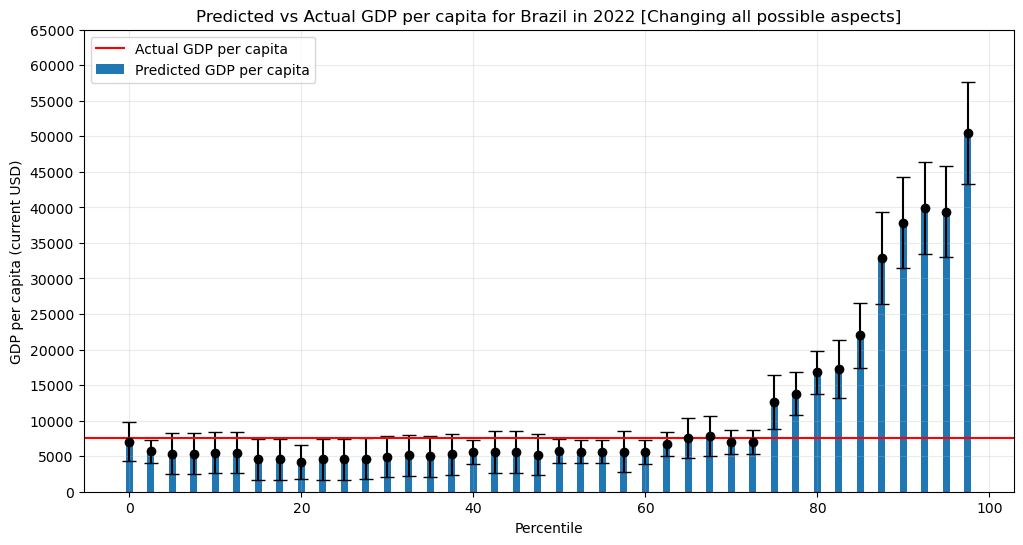

'Actual GDP per Capita: 7507.161'

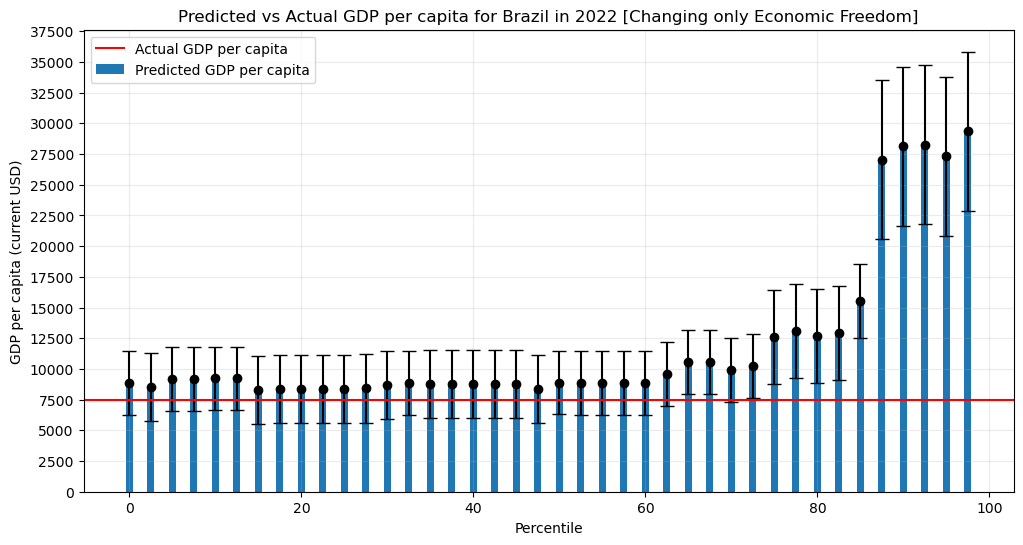

In [27]:
plot_GDP_projection('Brazil', model = gb_model)

plot_GDP_projection('Brazil',onlyEF=True, model = gb_model)

#### USA

'Actual GDP per Capita: 70248.629'

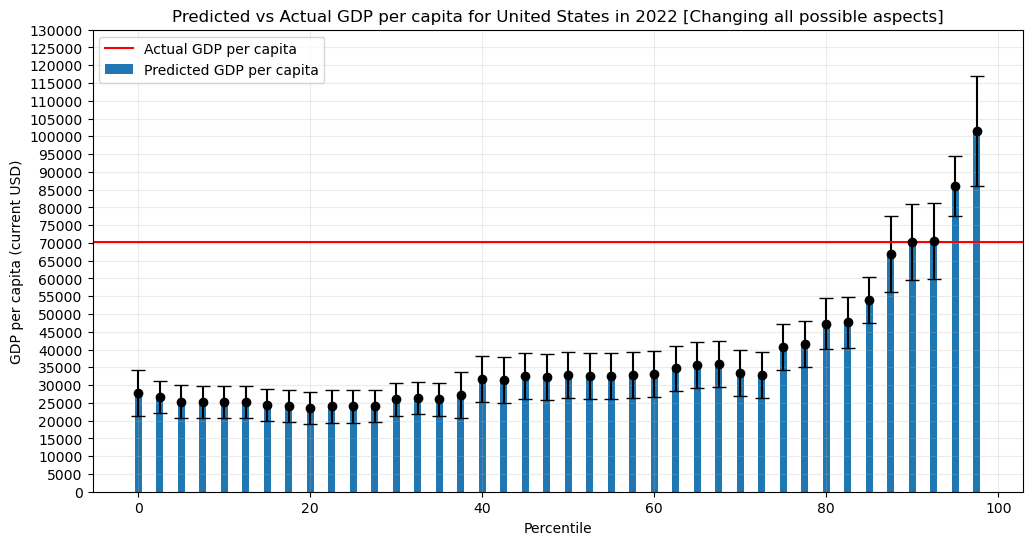

'Actual GDP per Capita: 70248.629'

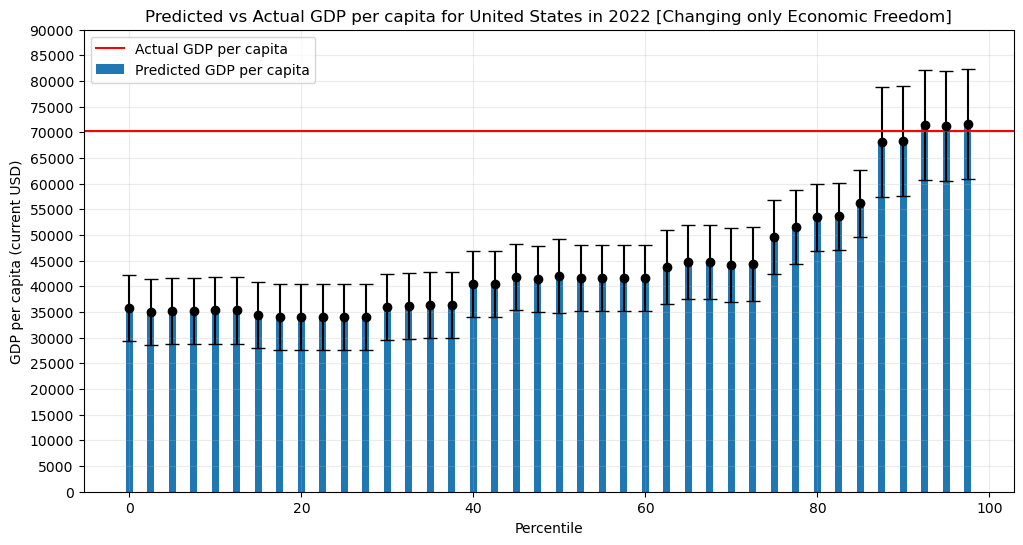

In [28]:
plot_GDP_projection('United States', model = gb_model)

plot_GDP_projection('United States',onlyEF=True, model = gb_model)

#### Germany


'Actual GDP per Capita: 51203.5545'

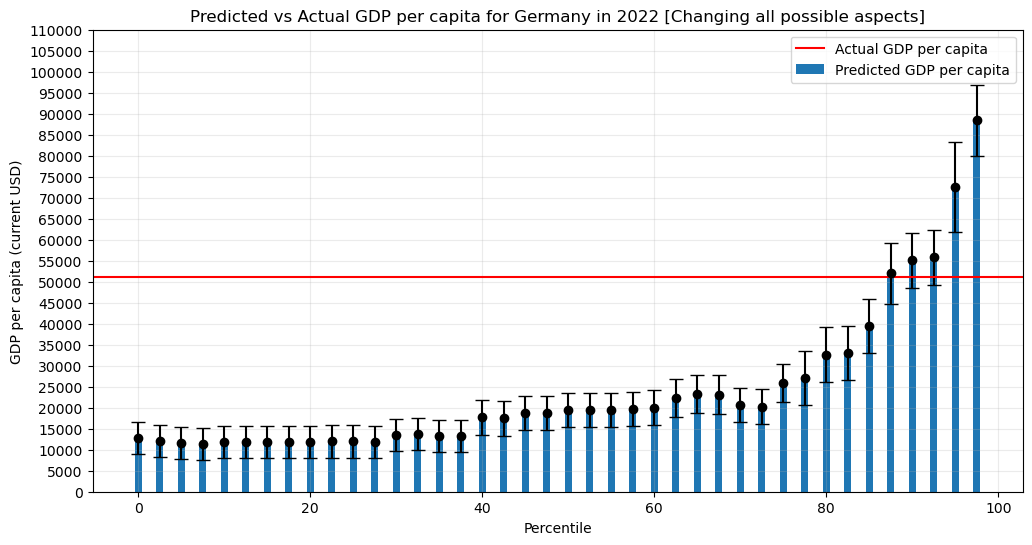

'Actual GDP per Capita: 51203.5545'

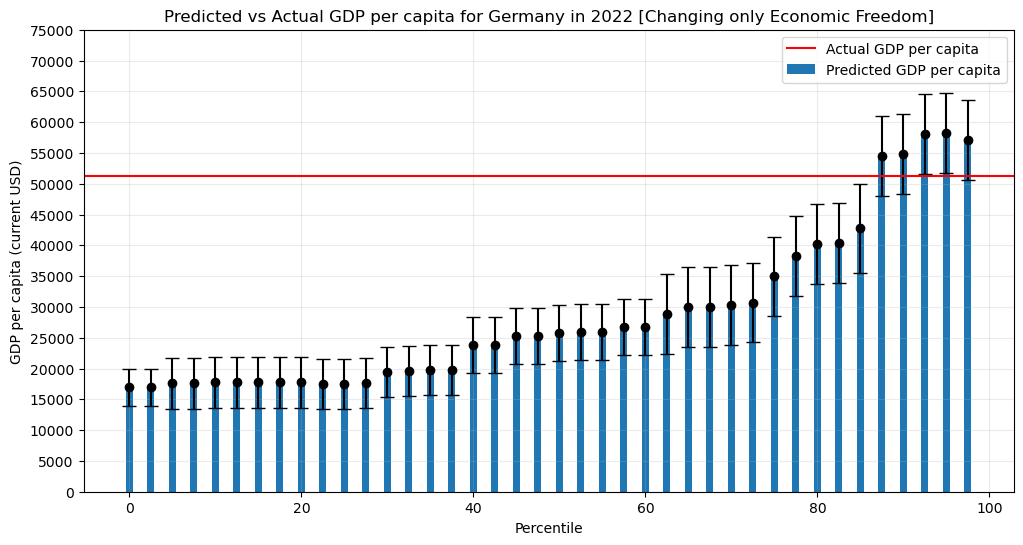

In [29]:
plot_GDP_projection('Germany', model = gb_model)

plot_GDP_projection('Germany',onlyEF=True, model = gb_model)

#### Estonia

'Actual GDP per Capita: 27943.7012'

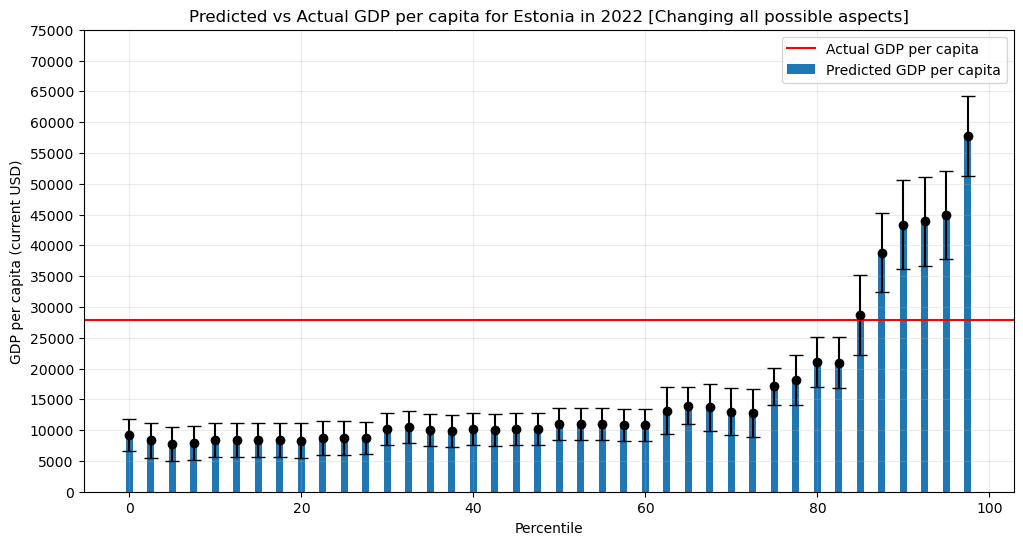

'Actual GDP per Capita: 27943.7012'

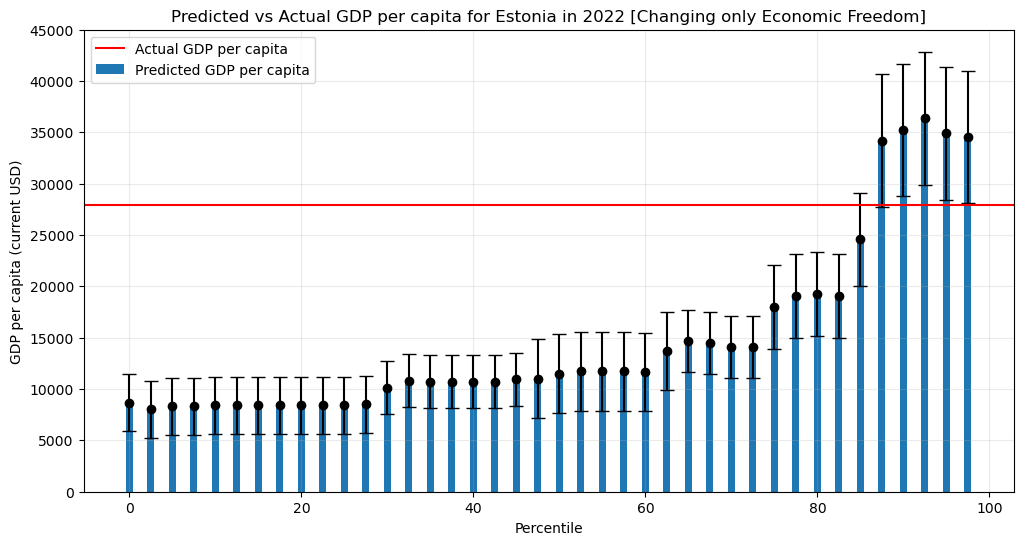

In [30]:
plot_GDP_projection('Estonia', model = gb_model)

plot_GDP_projection('Estonia',onlyEF=True, model = gb_model)

#### Botswana

'Actual GDP per Capita: 6805.2213'

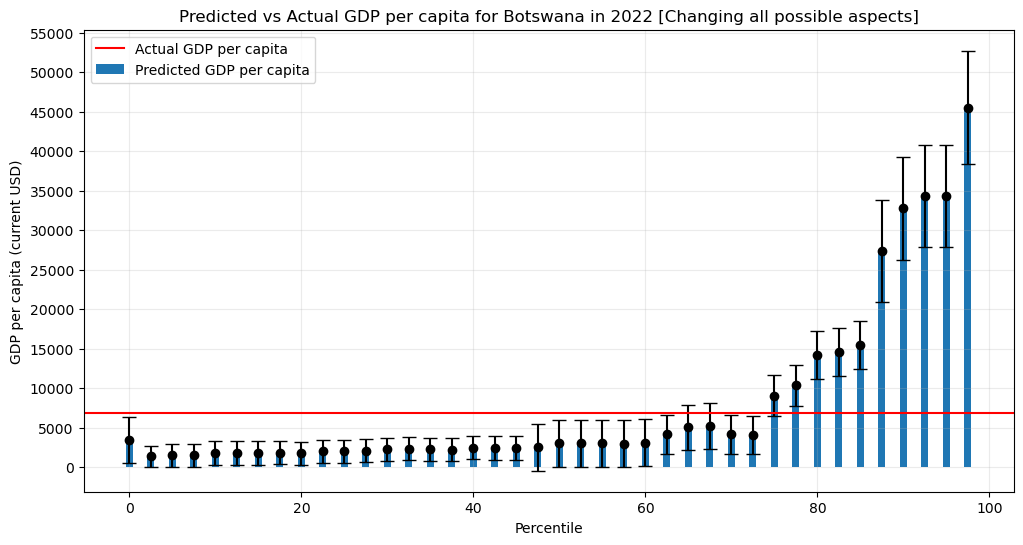

'Actual GDP per Capita: 6805.2213'

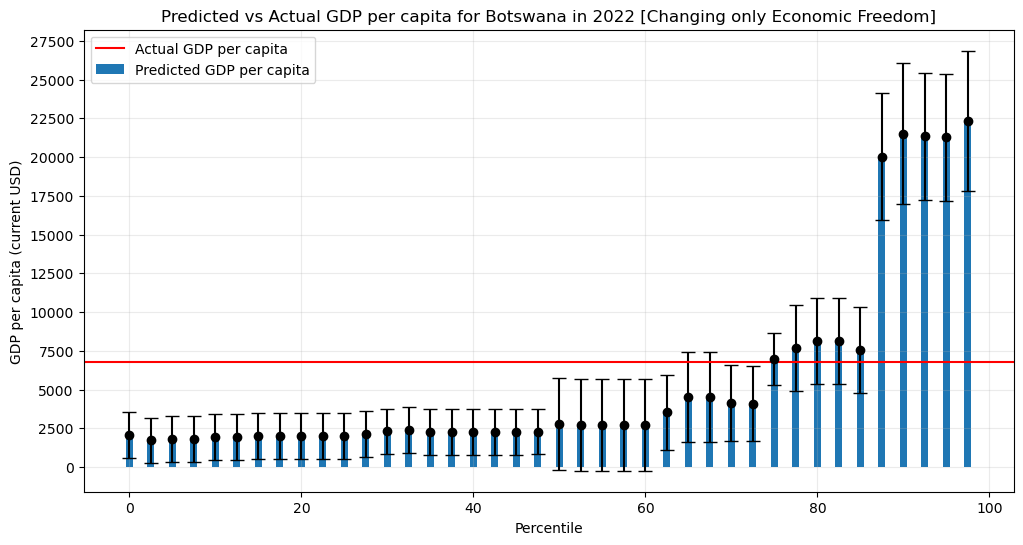

In [31]:
plot_GDP_projection('Botswana', model = gb_model)

plot_GDP_projection('Botswana',onlyEF=True, model = gb_model)